In [5]:
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
np.random.seed(0)

In [6]:
df = pd.read_csv('balanced_trad.csv')
df.head()

,t,l
0,why have i not got my new card?,11
1,Can you tell me if I can track the card you se...,11
2,How long will it take for me to get my card?,11
3,How long does it take for my new card to arriv...,11
4,Could I get tracking on the card?,11


In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [8]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import codecs


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [10]:
label_names = ["l"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['t'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)


In [11]:
from sklearn.utils import shuffle 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

raw_docs_train = train_df['t'].tolist()
raw_docs_test = test_df['t'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 2662/2662 [00:00<00:00, 6505.92it/s]


tokenizing input data...
dictionary size:  2521


In [12]:
# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

## Glove

In [13]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [14]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('/content/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


2196018it [03:59, 9184.49it/s]

found 2196016 word vectors


In [15]:
#embedding matrix

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 42


### LSTM

In [17]:
from keras.layers import BatchNormalization
import tensorflow as tf

def create_lstm_model():
  model_lstm = tf.keras.Sequential()
  model_lstm.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
  # model.add(SpatialDropout1D(0.7))
  model_lstm.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_lstm.add(Dense(128,activation='relu'))
  model_lstm.add(Dense(77, activation='softmax'))
  model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  return model_lstm


In [18]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_lstm_glove = create_lstm_model()

model_lstm_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 300)           756600    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 77)                9933      
                                                                 
Total params: 1,238,725
Trainable params: 482,125
Non-trainable params: 756,600
_________________________________________________________________


In [19]:
# from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_lstm_glove.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [20]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_lstm_glove.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 24s 607ms/step - loss: 4.2518 - accuracy: 0.0562 - val_loss: 3.9710 - val_accuracy: 0.1615
Epoch 2/40
30/30 [==============================] - 20s 669ms/step - loss: 3.5553 - accuracy: 0.1930 - val_loss: 2.5612 - val_accuracy: 0.3496
Epoch 3/40
30/30 [==============================] - 23s 755ms/step - loss: 2.4695 - accuracy: 0.3586 - val_loss: 1.7460 - val_accuracy: 0.5124
Epoch 4/40
30/30 [==============================] - 16s 521ms/step - loss: 1.9018 - accuracy: 0.4784 - val_loss: 1.3849 - val_accuracy: 0.6038
Epoch 5/40
30/30 [==============================] - 16s 528ms/step - loss: 1.5927 - accuracy: 0.5564 - val_loss: 1.1273 - val_accuracy: 0.6751
Epoch 6/40
30/30 [==============================] - 16s 520ms/step - loss: 1.4046 - accuracy: 0.5996 - val_loss: 1.0093 - val_accuracy: 0.7083
Epoch 7/40
30/30 [==============================] - 16s 521ms/step - loss: 1.2501 - accuracy: 0.6382 - val_loss: 0.8982 - val_accuracy: 0.7362
Epoch 8/40

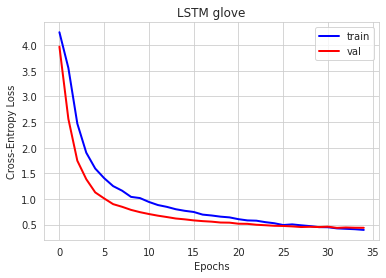

In [21]:
#generate plots
plt.figure()
plt.plot(history_glove.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

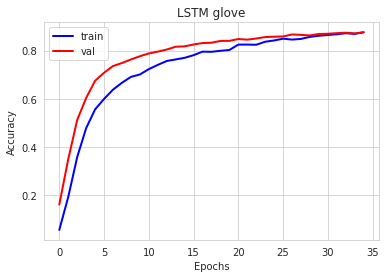

In [22]:
plt.figure()
plt.plot(history_glove.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [23]:
predictions = model_lstm_glove.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,23,23
2442,49,49
2859,59,47
12994,69,69
...,...,...
7532,27,27
3434,57,15
694,17,17
5168,68,68


In [24]:
import sklearn

print("Accuracy With glove LSTM:")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With glove LSTM:
0.8613824192336589


### CNN

In [27]:
#CNN architecture

num_filters = 64 

def create_cnn_model():
  model_cnn = Sequential()
  model_cnn.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(MaxPooling1D(2))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(GlobalMaxPooling1D())
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
  model_cnn.add(Dense(77, activation='softmax'))

  adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model_cnn


In [28]:
#CNN architecture
model_cnn_glove = create_cnn_model()
model_cnn_glove.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 300)           756600    
                                                                 
 conv1d (Conv1D)             (None, 19, 64)            134464    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 64)             28736     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_cnn_glove.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [30]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_cnn_glove.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 4s 107ms/step - loss: 4.3281 - accuracy: 0.0192 - val_loss: 4.2566 - val_accuracy: 0.0222
Epoch 2/40
30/30 [==============================] - 3s 98ms/step - loss: 4.1033 - accuracy: 0.0482 - val_loss: 3.7945 - val_accuracy: 0.1449
Epoch 3/40
30/30 [==============================] - 3s 99ms/step - loss: 3.5729 - accuracy: 0.1288 - val_loss: 3.0004 - val_accuracy: 0.2986
Epoch 4/40
30/30 [==============================] - 3s 102ms/step - loss: 2.8820 - accuracy: 0.2593 - val_loss: 2.2649 - val_accuracy: 0.4635
Epoch 5/40
30/30 [==============================] - 3s 100ms/step - loss: 2.3702 - accuracy: 0.3600 - val_loss: 1.8678 - val_accuracy: 0.5405
Epoch 6/40
30/30 [==============================] - 5s 166ms/step - loss: 2.0512 - accuracy: 0.4227 - val_loss: 1.5681 - val_accuracy: 0.5966
Epoch 7/40
30/30 [==============================] - 3s 103ms/step - loss: 1.7907 - accuracy: 0.4795 - val_loss: 1.3649 - val_accuracy: 0.6435
Epoch 8/40
30/30 [=

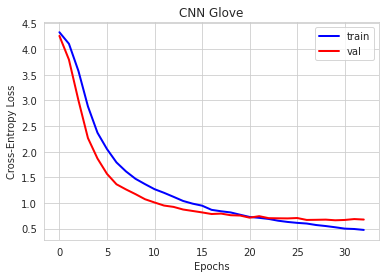

In [31]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN Glove')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

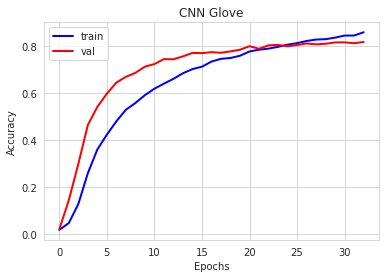

In [32]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN Glove')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [33]:
predictions = model_cnn_glove.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,23,23
2442,49,49
2859,54,47
12994,69,69
...,...,...
7532,27,27
3434,31,15
694,17,17
5168,68,68


In [34]:
import sklearn

print("Accuracy With glove CNN :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With glove CNN :
0.8065364387678438


### CNN + LSTM

In [35]:
def create_cnn_lstm_model():
  model_mix = Sequential()
  model_mix.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_mix.add(Dropout(0.2))
  model_mix.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_mix.add(MaxPooling1D(pool_size=4))
  model_mix.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_mix.add(Dense(128,activation='relu'))
  model_mix.add(Dense(77, activation='softmax'))
  model_mix.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model_mix


In [36]:
model_mix_glove = create_cnn_lstm_model()

In [37]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_mix_glove.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 11s 189ms/step - loss: 4.3079 - accuracy: 0.0204 - val_loss: 4.2156 - val_accuracy: 0.0382
Epoch 2/40
30/30 [==============================] - 5s 170ms/step - loss: 4.0825 - accuracy: 0.0601 - val_loss: 3.6229 - val_accuracy: 0.1308
Epoch 3/40
30/30 [==============================] - 5s 170ms/step - loss: 3.3650 - accuracy: 0.1605 - val_loss: 2.5609 - val_accuracy: 0.3149
Epoch 4/40
30/30 [==============================] - 5s 170ms/step - loss: 2.6582 - accuracy: 0.2661 - val_loss: 1.9886 - val_accuracy: 0.4385
Epoch 5/40
30/30 [==============================] - 5s 171ms/step - loss: 2.2392 - accuracy: 0.3521 - val_loss: 1.6469 - val_accuracy: 0.5321
Epoch 6/40
30/30 [==============================] - 5s 169ms/step - loss: 1.9858 - accuracy: 0.4126 - val_loss: 1.4551 - val_accuracy: 0.5818
Epoch 7/40
30/30 [==============================] - 5s 174ms/step - loss: 1.7653 - accuracy: 0.4679 - val_loss: 1.3003 - val_accuracy: 0.6160
Epoch 8/40
30/30

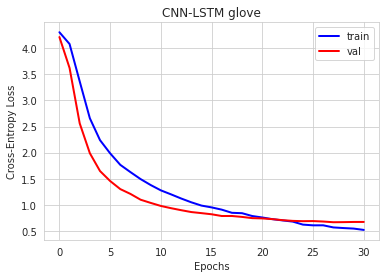

In [38]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

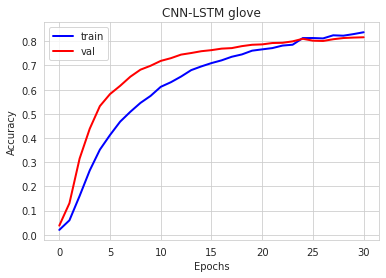

In [39]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [40]:
predictions = model_mix_glove.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,23,23
2442,49,49
2859,47,47
12994,69,69
...,...,...
7532,27,27
3434,39,15
694,31,17
5168,68,68


In [41]:
import sklearn

print("Accuracy With glove CNN-LSTM :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With glove CNN-LSTM :
0.8223140495867769


## Without word embedding
**texte en gras**

### LSTM

In [42]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_without_lstm = tf.keras.Sequential()

model_without_lstm.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, trainable=False))
model_without_lstm.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
model_without_lstm.add(Dense(128,activation='relu'))
model_without_lstm.add(Dense(77, activation='softmax'))
model_without_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_without_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 300)           756600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 77)                9933      
                                                                 
Total params: 1,238,725
Trainable params: 482,125
Non-trainable params: 756,600
_________________________________________________________________


In [43]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_without_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
# from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_without_lstm.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [45]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_without_lstm.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 22s 548ms/step - loss: 4.3362 - accuracy: 0.0145 - val_loss: 4.3283 - val_accuracy: 0.0244
Epoch 2/40
30/30 [==============================] - 16s 525ms/step - loss: 4.2997 - accuracy: 0.0374 - val_loss: 4.2681 - val_accuracy: 0.0416
Epoch 3/40
30/30 [==============================] - 16s 528ms/step - loss: 4.1890 - accuracy: 0.0531 - val_loss: 4.0813 - val_accuracy: 0.0664
Epoch 4/40
30/30 [==============================] - 16s 531ms/step - loss: 3.9612 - accuracy: 0.0853 - val_loss: 3.6913 - val_accuracy: 0.1033
Epoch 5/40
30/30 [==============================] - 17s 555ms/step - loss: 3.6485 - accuracy: 0.1177 - val_loss: 3.3869 - val_accuracy: 0.1493
Epoch 6/40
30/30 [==============================] - 16s 530ms/step - loss: 3.4036 - accuracy: 0.1526 - val_loss: 3.0226 - val_accuracy: 0.2272
Epoch 7/40
30/30 [==============================] - 17s 581ms/step - loss: 3.1775 - accuracy: 0.1924 - val_loss: 2.8258 - val_accuracy: 0.2567
Epoch 8/40

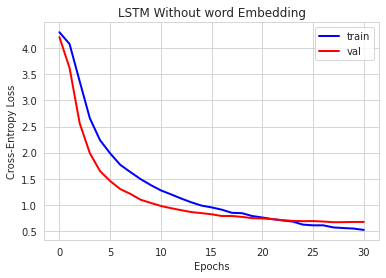

In [46]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM Without word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

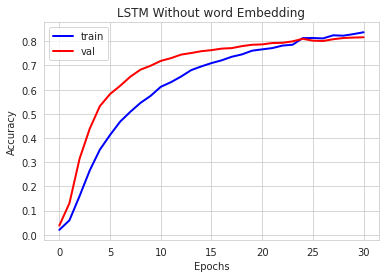

In [47]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM Without word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [48]:
predictions = model_without_lstm.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,68,23
2442,49,49
2859,66,47
12994,69,69
...,...,...
7532,27,27
3434,57,15
694,31,17
5168,68,68


In [49]:
import sklearn

print("Accuracy Without word Embedding LSTM:")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy Without word Embedding LSTM:
0.6923365890308039


### CNN

In [50]:
num_filters = 64 

In [51]:
#CNN architecture
model_cnn = Sequential()
model_cnn.add(Embedding(nb_words, embed_dim, input_length=max_seq_len, trainable=False))
model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model_cnn.add(Dense(77, activation='softmax'))

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 19, 300)           756600    
                                                                 
 conv1d_3 (Conv1D)           (None, 19, 64)            134464    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 64)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 9, 64)             28736     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 64)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [52]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_cnn.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [53]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_cnn.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 4s 108ms/step - loss: 4.3469 - accuracy: 0.0146 - val_loss: 4.3415 - val_accuracy: 0.0163
Epoch 2/40
30/30 [==============================] - 3s 103ms/step - loss: 4.3307 - accuracy: 0.0173 - val_loss: 4.3117 - val_accuracy: 0.0300
Epoch 3/40
30/30 [==============================] - 3s 103ms/step - loss: 4.2628 - accuracy: 0.0278 - val_loss: 4.1953 - val_accuracy: 0.0407
Epoch 4/40
30/30 [==============================] - 3s 103ms/step - loss: 4.1134 - accuracy: 0.0400 - val_loss: 3.9870 - val_accuracy: 0.0770
Epoch 5/40
30/30 [==============================] - 3s 101ms/step - loss: 3.8917 - accuracy: 0.0721 - val_loss: 3.6529 - val_accuracy: 0.1293
Epoch 6/40
30/30 [==============================] - 3s 102ms/step - loss: 3.5465 - accuracy: 0.1096 - val_loss: 3.2279 - val_accuracy: 0.1922
Epoch 7/40
30/30 [==============================] - 3s 103ms/step - loss: 3.2206 - accuracy: 0.1535 - val_loss: 2.9312 - val_accuracy: 0.2604
Epoch 8/40
30/30 

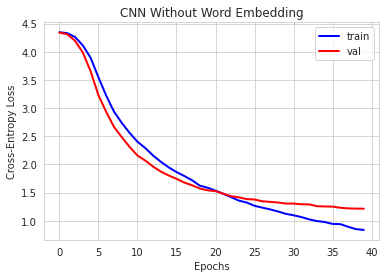

In [54]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

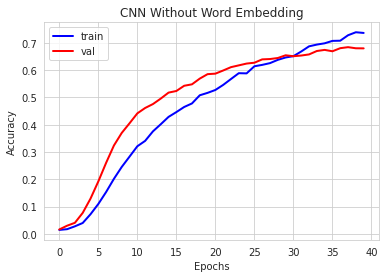

In [55]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [56]:
predictions = model_cnn.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,16,23
2442,49,49
2859,28,47
12994,69,69
...,...,...
7532,27,27
3434,73,15
694,33,17
5168,74,68


In [57]:
import sklearn

print("Accuracy Without word embedding CNN :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy Without word embedding CNN :
0.6750563486100676


### CNN + LSTM

In [58]:
model_mix_without_w_e = Sequential()
model_mix_without_w_e.add(Embedding(nb_words, embed_dim,  input_length=max_seq_len, trainable=False))
model_mix_without_w_e.add(Dropout(0.2))
model_mix_without_w_e.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model_mix_without_w_e.add(MaxPooling1D(pool_size=4))
model_mix_without_w_e.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
model_mix_without_w_e.add(Dense(128,activation='relu'))
model_mix_without_w_e.add(Dense(77, activation='softmax'))
model_mix_without_w_e.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  


In [59]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_mix_without_w_e.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 12s 189ms/step - loss: 4.3422 - accuracy: 0.0138 - val_loss: 4.3391 - val_accuracy: 0.0200
Epoch 2/40
30/30 [==============================] - 5s 169ms/step - loss: 4.3188 - accuracy: 0.0215 - val_loss: 4.2904 - val_accuracy: 0.0247
Epoch 3/40
30/30 [==============================] - 5s 168ms/step - loss: 4.2317 - accuracy: 0.0275 - val_loss: 4.1702 - val_accuracy: 0.0282
Epoch 4/40
30/30 [==============================] - 5s 167ms/step - loss: 4.0807 - accuracy: 0.0340 - val_loss: 4.0039 - val_accuracy: 0.0407
Epoch 5/40
30/30 [==============================] - 5s 169ms/step - loss: 3.9274 - accuracy: 0.0409 - val_loss: 3.8423 - val_accuracy: 0.0532
Epoch 6/40
30/30 [==============================] - 5s 167ms/step - loss: 3.8058 - accuracy: 0.0552 - val_loss: 3.6831 - val_accuracy: 0.0845
Epoch 7/40
30/30 [==============================] - 6s 193ms/step - loss: 3.6571 - accuracy: 0.0756 - val_loss: 3.4909 - val_accuracy: 0.1214
Epoch 8/40
30/30

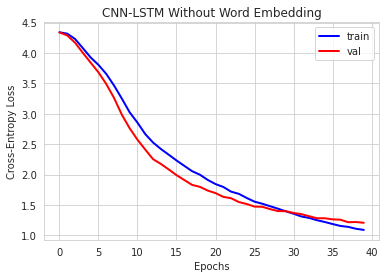

In [60]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

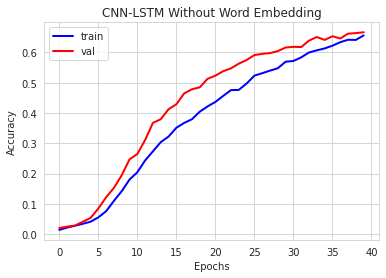

In [61]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [62]:
predictions = model_mix_without_w_e.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,24,23
2442,49,49
2859,47,47
12994,74,69
...,...,...
7532,27,27
3434,1,15
694,76,17
5168,68,68


In [63]:
import sklearn

print("Accuracy Without Word Embedding CNN-LSTM :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy Without Word Embedding CNN-LSTM :
0.6333583771600301
